In [1]:
import pysbm
import networkx as nx
import matplotlib.pylab as plt
import pandas as pd
import numpy as np


In [2]:
post_df = pd.read_pickle("C:\\Users\\EbiharaYuito\\sotsuken\\pysbm\\pysbm\\Network Data\\sorted_id_count_fiscal_2013_enriched_top100.pkl")
post_df.head()

,item_id,count,category_id1,category_id2,average_price,first_price,max_price,price,posts
0,1084549,3185,15,15005,3360.0,3360,3360,3360,"[{'user': 8042, 'date': 2013-01-04 00:00:00}, ..."
1,1084556,3182,15,15005,3360.0,3360,3360,3360,"[{'user': 29440, 'date': 2012-12-18 00:00:00},..."
2,1084550,3177,15,15005,3360.0,3360,3360,3360,"[{'user': 39749, 'date': 2013-01-15 00:00:00},..."
3,1084552,3175,15,15005,3360.0,3360,3360,3360,"[{'user': 83657, 'date': 2012-12-22 00:00:00},..."
4,1084551,3172,15,15005,3360.0,3360,3360,3360,"[{'user': 39749, 'date': 2013-01-15 00:00:00},..."


In [3]:
#item_idとpostsに含まれるuserの値を使って有向2部グラフを作成する
#2013年12月31日までのデータを使用する

import networkx as nx
import datetime
# Create an empty directed graph
graph = nx.DiGraph()

# Iterate through the DataFrame rows
for index, row in post_df.iterrows():
    item_id = row['item_id']
    item_node_name = "item_" + str(item_id)
    posts = row['posts']
    
    # Add item_id as a node (assuming it's a valid identifier)
    graph.add_node(item_node_name, bipartite=0)  # bipartite=0 for items
    
    posted_users = []
    for post in posts:
      if post["date"] <= datetime.datetime(2013, 12, 31):
        posted_users.append(post["user"])
        
    for user in posted_users:
        user_node_name = "user_" + str(user)
        graph.add_node(user_node_name, bipartite=1)  # bipartite=1 for users
        if not graph.has_edge(user_node_name, item_node_name):  # エッジが存在しない場合のみ追加
            graph.add_edge(user_node_name, item_node_name) # user points to item
                
# Now the 'graph' object contains your bipartite graph

In [4]:
# ユーザーごとの投稿数を計算
user_post_counts = {}
for node in graph.nodes():
    if node.startswith('user_'):
        user_post_counts[node] = graph.out_degree(node)

# 投稿数の多い上位200ユーザーを取得
top_users = sorted(user_post_counts.items(), key=lambda x: x[1], reverse=True)[200:600]
top_user_nodes = [user[0] for user in top_users]

# 新しいグラフを作成
filtered_graph = graph.copy()

# 上位200ユーザー以外のユーザーノードを削除
users_to_remove = [node for node in graph.nodes() if node.startswith('user_') and node not in top_user_nodes]
filtered_graph.remove_nodes_from(users_to_remove)

# 孤立したアイテムノードを削除
isolated_nodes = list(nx.isolates(filtered_graph))
filtered_graph.remove_nodes_from(isolated_nodes)

# 元のグラフを更新
graph = filtered_graph


In [5]:
# prompt: グラフの情報を確認する

print("Number of nodes:", graph.number_of_nodes())
print("Number of edges:", graph.number_of_edges())
print("Density of the graph:", nx.density(graph))
# check if the graph is directed or undirected
print("Is directed:", nx.is_directed(graph))

# # Check for strongly connected components
# scc = list(nx.strongly_connected_components(graph))
# print("Strongly connected components:", scc)

# # Check for weakly connected components
# wcc = list(nx.weakly_connected_components(graph))
# print("Weakly connected components:", wcc)

# Calculate degree centrality for items
item_degree_centrality = nx.degree_centrality(graph)
print("Item degree centrality:", sorted(item_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10])

# Calculate degree centrality for users
user_degree_centrality = nx.degree_centrality(graph)
print("User degree centrality:", sorted(user_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10])

Number of nodes: 500
Number of edges: 8429
Density of the graph: 0.033783567134268534
Is directed: True
Item degree centrality: [('item_1084549', 0.3607214428857715), ('item_1084556', 0.3607214428857715), ('item_1084550', 0.3607214428857715), ('item_1084552', 0.3607214428857715), ('item_1084551', 0.3607214428857715), ('item_1084553', 0.3607214428857715), ('item_2232034', 0.3426853707414829), ('item_2188911', 0.33266533066132264), ('item_1980446', 0.3246492985971944), ('item_2136071', 0.3106212424849699)]
User degree centrality: [('item_1084549', 0.3607214428857715), ('item_1084556', 0.3607214428857715), ('item_1084550', 0.3607214428857715), ('item_1084552', 0.3607214428857715), ('item_1084551', 0.3607214428857715), ('item_1084553', 0.3607214428857715), ('item_2232034', 0.3426853707414829), ('item_2188911', 0.33266533066132264), ('item_1980446', 0.3246492985971944), ('item_2136071', 0.3106212424849699)]


In [6]:
standard_partition = pysbm.NxPartition(
    graph=graph, 
    number_of_blocks=5)
# degree_corrected_partition = pysbm.NxPartition(
#     graph=graph, 
#     number_of_blocks=5,
#     representation=standard_partition.get_representation())
standard_objective_function = pysbm.TraditionalUnnormalizedLogLikelyhood(is_directed=True)
# degree_corrected_objective_function = pysbm.DegreeCorrectedUnnormalizedLogLikelyhood(is_directed=False)

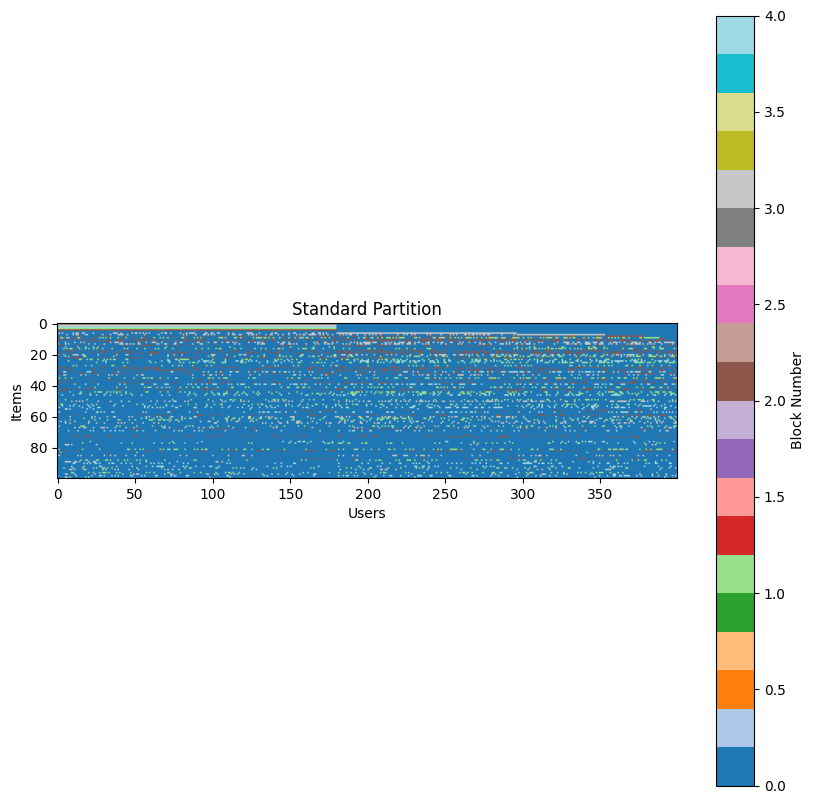

In [7]:
# グラフを隣接行列に変換
items = [n for n in graph.nodes() if graph.nodes[n]['bipartite'] == 0]
users = [n for n in graph.nodes() if graph.nodes[n]['bipartite'] == 1]
adj_matrix = np.zeros((len(items), len(users)))

# 行列を作成
for i, item in enumerate(items):
    for j, user in enumerate(users):
        if graph.has_edge(item, user) or graph.has_edge(user, item):
            adj_matrix[i,j] = standard_partition.get_block_of_node(item)

# 行列をプロット
plt.figure(figsize=(10,10))
plt.imshow(adj_matrix, cmap='tab20')
plt.title('Standard Partition')
plt.xlabel('Users')
plt.ylabel('Items')
plt.colorbar(label='Block Number')
plt.show()

# # 同様に degree corrected partition も表示
# plt.figure(figsize=(10,10))
# plt.imshow(adj_matrix, cmap='binary')
# plt.title('Degree Corrected Partition')
# plt.xlabel('Users')
# plt.ylabel('Items')
# plt.show()

In [8]:
standard_inference = pysbm.MetropolisHastingInference(graph, standard_objective_function, standard_partition)
# degree_corrected_inference = pysbm.MetropolisHastingInference(graph, degree_corrected_objective_function, degree_corrected_partition)

In [13]:
from tqdm import tqdm  # 進行バーの表示用

best_partition = None
best_value = float('-inf')

partition = pysbm.NxPartition(
    graph=graph, 
    number_of_blocks=10
)
    
inference = pysbm.MetropolisHastingInference(
    graph=graph,
    objective_function=standard_objective_function,
    partition=partition
)

for step in range(50000):
    inference.infer_stepwise()
    if step % 100 == 0:  # 100ステップごとに評価
        current_value = standard_objective_function.calculate(partition)
        if current_value > best_value:
            best_value = current_value
            best_partition = partition.get_representation()
            print(f"Step {step}: New best value {best_value}")

Step 0: New best value -28123.10574855574
Step 100: New best value -27683.77833570955
Step 200: New best value -27139.58781536857
Step 300: New best value -26531.790945013894
Step 400: New best value -25645.425563090757
Step 500: New best value -24676.66541529067
Step 600: New best value -23969.44952902551
Step 700: New best value -23095.295839771607
Step 800: New best value -22294.45052614597
Step 900: New best value -21239.195132896635
Step 1000: New best value -19664.64029385851
Step 1100: New best value -19070.48376405379
Step 1200: New best value -18251.7745509354
Step 1300: New best value -17737.262858282542
Step 1400: New best value -17132.04035038501
Step 1500: New best value -16396.99218946221
Step 1600: New best value -16083.557837081395
Step 1700: New best value -15879.13047503673
Step 1800: New best value -15576.826350778027
Step 1900: New best value -14976.676604099252
Step 2000: New best value -14864.029376165623
Step 2100: New best value -14382.795680536612
Step 2200: Ne

In [14]:
# standard_inference.infer_stochastic_block_model()
# degree_corrected_inference.infer_stochastic_block_model()

NameError: name 'standard_inference' is not defined

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8,

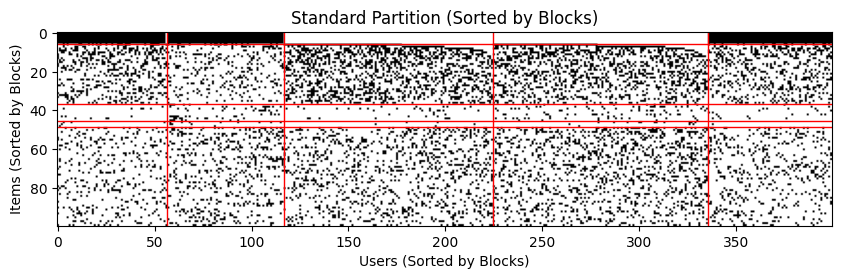

In [16]:
# ノードをブロックごとにソート
items_sorted = sorted(items, key=lambda x: partition.get_block_of_node(x))
users_sorted = sorted(users, key=lambda x: partition.get_block_of_node(x))

# ブロックの境界を見つける
item_blocks = [partition.get_block_of_node(item) for item in items_sorted]
print(item_blocks)
user_blocks = [partition.get_block_of_node(user) for user in users_sorted]
print(user_blocks)
item_boundaries = [i for i in range(1, len(item_blocks)) if item_blocks[i] != item_blocks[i-1]]
user_boundaries = [i for i in range(1, len(user_blocks)) if user_blocks[i] != user_blocks[i-1]]

# 並び替えた行列を作成
adj_matrix_sorted = np.zeros((len(items), len(users)))
for i, item in enumerate(items_sorted):
    for j, user in enumerate(users_sorted):
        if graph.has_edge(item, user) or graph.has_edge(user, item):
            adj_matrix_sorted[i,j] = 1

# 並び替えた行列をプロット
plt.figure(figsize=(10,10))
plt.imshow(adj_matrix_sorted, cmap='binary')

# ブロックの境界に線を追加
for boundary in item_boundaries:
    plt.axhline(y=boundary-0.5, color='r', linestyle='-', linewidth=1)
for boundary in user_boundaries:
    plt.axvline(x=boundary-0.5, color='r', linestyle='-', linewidth=1)

plt.title('Standard Partition (Sorted by Blocks)')
plt.xlabel('Users (Sorted by Blocks)')
plt.ylabel('Items (Sorted by Blocks)')
plt.show()


[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8,

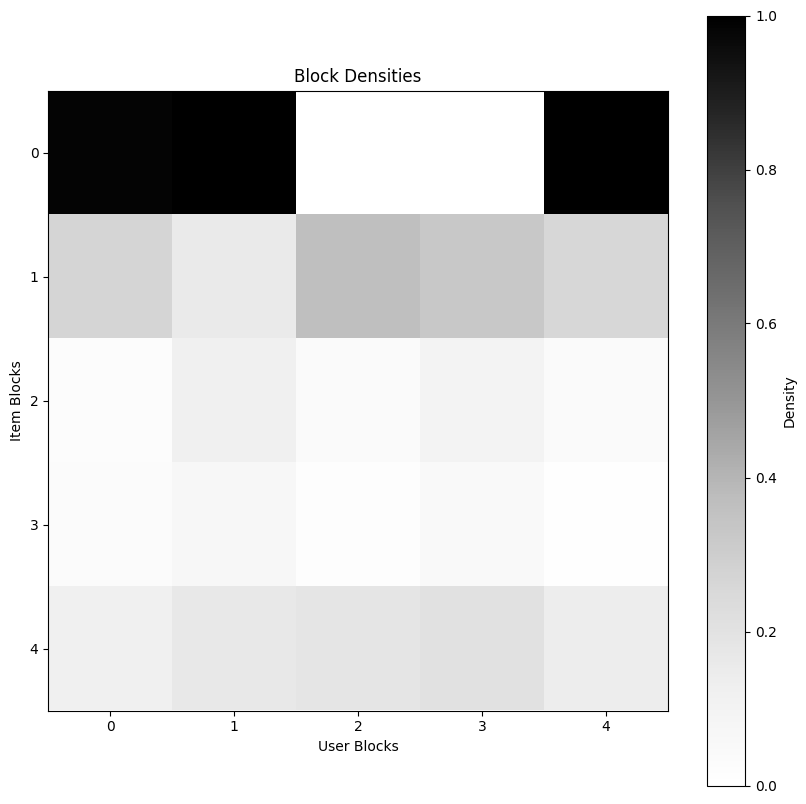

In [19]:
# ノードをブロックごとにソート
items_sorted = sorted(items, key=lambda x: partition.get_block_of_node(x))
users_sorted = sorted(users, key=lambda x: partition.get_block_of_node(x))

# ブロックの境界を見つける
item_blocks = [partition.get_block_of_node(item) for item in items_sorted]
print(item_blocks)
user_blocks = [partition.get_block_of_node(user) for user in users_sorted]
print(user_blocks)
item_boundaries = [i for i in range(1, len(item_blocks)) if item_blocks[i] != item_blocks[i-1]]
user_boundaries = [i for i in range(1, len(user_blocks)) if user_blocks[i] != user_blocks[i-1]]

# ブロックサイズを計算
item_block_sizes = []
user_block_sizes = []
prev_boundary = 0
for boundary in item_boundaries:
    item_block_sizes.append(boundary - prev_boundary)
    prev_boundary = boundary
item_block_sizes.append(len(items) - prev_boundary)

prev_boundary = 0
for boundary in user_boundaries:
    user_block_sizes.append(boundary - prev_boundary)
    prev_boundary = boundary
user_block_sizes.append(len(users) - prev_boundary)

# ブロックごとの密度を計算
num_item_blocks = len(item_block_sizes)
num_user_blocks = len(user_block_sizes)
block_densities = np.zeros((num_item_blocks, num_user_blocks))

start_i = 0
for i in range(num_item_blocks):
    size_i = item_block_sizes[i]
    start_j = 0
    for j in range(num_user_blocks):
        size_j = user_block_sizes[j]
        block = adj_matrix_sorted[start_i:start_i+size_i, start_j:start_j+size_j]
        density = np.sum(block) / (size_i * size_j)
        block_densities[i,j] = density
        start_j += size_j
    start_i += size_i

# ブロック密度をプロット
plt.figure(figsize=(10,10))
plt.imshow(block_densities, cmap='Greys')

# # ブロックの境界に線を追加
# for boundary in item_boundaries:
#     plt.axhline(y=boundary-0.5, color='r', linestyle='-', linewidth=1)
# for boundary in user_boundaries:
#     plt.axvline(x=boundary-0.5, color='r', linestyle='-', linewidth=1)

plt.title('Block Densities')
plt.xlabel('User Blocks')
plt.ylabel('Item Blocks')
plt.colorbar(label='Density')
plt.show()


Standard SBM with the splitting into high and low degree nodes


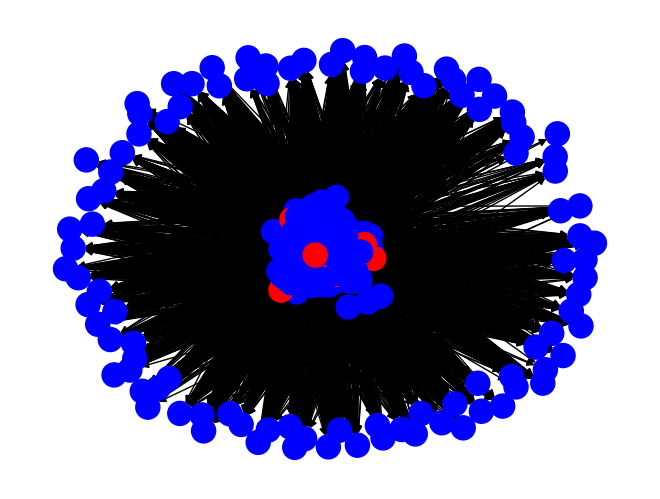

In [11]:
position = nx.spring_layout(graph)
print("Standard SBM with the splitting into high and low degree nodes")
nx.draw(graph, position, node_color=['r' if standard_partition.get_block_of_node(node) == 0 else 'b' for node in graph])
plt.show()
# print("Degree Corrected SBM")
# nx.draw(graph, position, node_color=['r' if degree_corrected_partition.get_block_of_node(node) == 0 else 'b' for node in graph])
# plt.show()